In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import title
from pandas.core.interchange.from_dataframe import primitive_column_to_ndarray

# Introduction
This notebook contains example code for loading and processing the UK HAM dataset to produce a netCDF file used when running JULES.

In [2]:
src_file = "../Example_data/AliceHolt_2022_flux&met_ver2.csv"

# Load the csv file
df = pd.read_csv(src_file, index_col='DateTime', parse_dates=True )

# Print data shape
print("Data : ", df.head)

Data :  <bound method NDFrame.head of                      Unnamed: 0 filename date.x time  DOY  daytime  \
DateTime                                                             
2022-01-01 00:00:00           1      NaN    NaN  NaN  NaN      NaN   
2022-01-01 00:30:00           2      NaN    NaN  NaN  NaN      NaN   
2022-01-01 01:00:00           3      NaN    NaN  NaN  NaN      NaN   
2022-01-01 01:30:00           4      NaN    NaN  NaN  NaN      NaN   
2022-01-01 02:00:00           5      NaN    NaN  NaN  NaN      NaN   
...                         ...      ...    ...  ...  ...      ...   
2022-12-31 21:30:00       17516      NaN    NaN  NaN  NaN      NaN   
2022-12-31 22:00:00       17517      NaN    NaN  NaN  NaN      NaN   
2022-12-31 22:30:00       17518      NaN    NaN  NaN  NaN      NaN   
2022-12-31 23:00:00       17519      NaN    NaN  NaN  NaN      NaN   
2022-12-31 23:30:00       17520      NaN    NaN  NaN  NaN      NaN   

                     file_records  used_records  Ta

# Data processing
The first step is to reduce the data to those columns needed for the netCDF file. The columns needed are:

| column name     | description                         | units     |
|:----------------|:------------------------------------|:----------|
| DateTime        | Date and time of the measurement    |           |
| air_temperature | Air temperature                     |           |
| air_pressure    | Air pressure                        |           |
| PAR_Den_Avg     | Photosynthetically active radiation |           |
| Rn_Avg          |                                     |           |
| u*              |                                     |           |
| Rain_mm_Tot     | Total rainfall                      |           |
| VPD             | Vapour pressure deficit             |           |
| LE              | Latent heat flux                    |           |
| RH              | Relative humidity                   |           |
| WS_ms_Avg       |  Wind speed                         | $ms^{-1}$ |

In [3]:
# Note: we don't need to specify the date time column as it is the index
df = df[['air_temperature',
         'air_pressure',
         'PAR_Den_Avg',
         'Rn_Avg',
         'u*',
         'Rain_mm_Tot',
         'VPD', 
         'LE', 
         'RH',
         'WS_ms_Avg']]
print(df.head)

<bound method NDFrame.head of                      air_temperature  air_pressure  PAR_Den_Avg  Rn_Avg  u*  \
DateTime                                                                      
2022-01-01 00:00:00              NaN           NaN          0.0  -2.972 NaN   
2022-01-01 00:30:00              NaN           NaN          0.0  -2.478 NaN   
2022-01-01 01:00:00              NaN           NaN          0.0  -2.294 NaN   
2022-01-01 01:30:00              NaN           NaN          0.0  -2.938 NaN   
2022-01-01 02:00:00              NaN           NaN          0.0  -5.443 NaN   
...                              ...           ...          ...     ...  ..   
2022-12-31 21:30:00              NaN           NaN          0.0 -14.620 NaN   
2022-12-31 22:00:00              NaN           NaN          0.0 -21.360 NaN   
2022-12-31 22:30:00              NaN           NaN          0.0 -18.420 NaN   
2022-12-31 23:00:00              NaN           NaN          0.0 -16.140 NaN   
2022-12-31 23:30:00   

We now need to rename the columns to match the names expected by JULES.

In [4]:
df = df.rename(columns={'Rain_mm_Tot': 'Rainf',
                        'air_pressure': 'Psurf',
                        'air_temperature': 'Tair',
                        'PAR_Den_Avg': 'PAR',
                        'Rn_Avg': 'Rnet',
                        'u*': 'Ustar',
                        'WS_ms_Avg': 'Wind'})

print(df.keys())

Index(['Tair', 'Psurf', 'PAR', 'Rnet', 'Ustar', 'Rainf', 'VPD', 'LE', 'RH',
       'Wind'],
      dtype='object')


## Adding CO2 data

Next we need to add CO2 to the data frame.

                     Tair  Psurf  PAR   Rnet  Ustar  Rainf  VPD  LE  RH  \
DateTime                                                                  
2022-01-01 00:00:00   NaN    NaN  0.0 -2.972    NaN    0.0  NaN NaN NaN   
2022-01-01 00:30:00   NaN    NaN  0.0 -2.478    NaN    0.0  NaN NaN NaN   
2022-01-01 01:00:00   NaN    NaN  0.0 -2.294    NaN    0.0  NaN NaN NaN   
2022-01-01 01:30:00   NaN    NaN  0.0 -2.938    NaN    0.0  NaN NaN NaN   
2022-01-01 02:00:00   NaN    NaN  0.0 -5.443    NaN    0.0  NaN NaN NaN   

                      Wind  CO2air  
DateTime                            
2022-01-01 00:00:00  2.554  418.56  
2022-01-01 00:30:00  2.621  418.56  
2022-01-01 01:00:00  3.054  418.56  
2022-01-01 01:30:00  2.392  418.56  
2022-01-01 02:00:00  3.003  418.56  


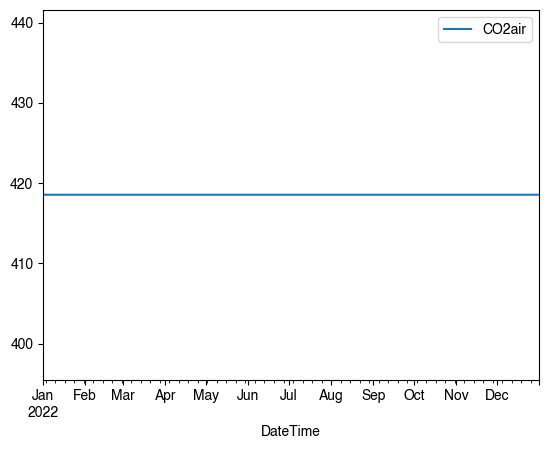

In [5]:
co2_fname = "../Example_data/co2_annmean_mlo.csv"

df_co2 = pd.read_csv(co2_fname, header=59, index_col=0, parse_dates=[0])
df_co2 = df_co2.drop('unc', axis=1)

df['CO2air'] = -999.9 # fix later
unique_yrs = np.unique(df.index.year)
for yr in unique_yrs:

    years_co2 = df_co2[df_co2.index.year == yr].values[0][0]

    idx = df.index[df.index.year==yr].tolist()

    df.loc[idx, 'CO2air'] = years_co2


print(df.head())

df.plot(y='CO2air')
plt.show()

## Gap filling

Jules is unable to handle missing data so it is necessary to fill any gaps in the data.

First we fill any missing ranifall with zero.

In [6]:
## Fill rainfall gaps with 0
df['Rainf'] = df['Rainf'].fillna(0)

Next we remove any instances where the wind speed is bellow 0.1 m/s by setting them to NaN.

In [7]:
# Account for the very, very low wind speeds as these are values but bunk
# So, set it so we can then gap fill
df.Wind = np.where(df.Wind < 0.1, np.nan, df.Wind)

The final step is to forward fill any missing data. This means that any NaN values are replaced with the previous non-NaN value. Where there are multiple NaN values the fill value is found by working backwards till a non-NaN value is found.

To account for any NaN values at the start of the data we also backfill the data.

In [8]:
# Fill by the hour of day average
df = df.groupby(df.index.hour).ffill()
df = df.groupby(df.index.hour).bfill()

print(df.head())

                        Tair     Psurf  PAR   Rnet     Ustar  Rainf      VPD  \
DateTime                                                                       
2022-01-01 00:00:00  289.322  101608.0  0.0 -2.972  0.518448    0.0  752.751   
2022-01-01 00:30:00  289.322  101608.0  0.0 -2.478  0.518448    0.0  752.751   
2022-01-01 01:00:00  287.886  101628.0  0.0 -2.294  0.598314    0.0  586.710   
2022-01-01 01:30:00  287.886  101628.0  0.0 -2.938  0.598314    0.0  586.710   
2022-01-01 02:00:00  286.193  101659.0  0.0 -5.443  0.503715    0.0  420.788   

                           LE       RH   Wind  CO2air  
DateTime                                               
2022-01-01 00:00:00 -2.019580  58.9187  2.554  418.56  
2022-01-01 00:30:00 -2.019580  58.9187  2.621  418.56  
2022-01-01 01:00:00 -0.760662  64.8896  3.054  418.56  
2022-01-01 01:30:00 -0.760662  64.8896  2.392  418.56  
2022-01-01 02:00:00 -1.792900  71.8934  3.003  418.56  


# Converting units
Some of the columns don't have the correct units for JULES.

First we convert the uits for rain from mm/h to mm/s.

In [9]:
df.loc[:, 'Rainf'] /= 1800 ## mm/sec

Convert the relative humidity to specific humidity.

In [10]:
from src.Conversions.humidity import convert_rh_to_qair

df['Qair'] = convert_rh_to_qair(df['Tair'], df['Psurf'], df['RH'])

Limit the VPD to a minimum of 0.05

In [11]:
df['VPD'] = np.where(df['VPD'] < 0.05, 0.05, df['VPD'])

Estimate the longwave radiation.

In [12]:
from src.Conversions.light import estimate_lwdown

df['LWdown'] = estimate_lwdown(df.Tair.values, df.RH.values/100.)

Calculate the short wave radiation from the photosynthetically active radiation.

In [13]:
df['Swdown'] = df['PAR'] / 2.3

In [14]:
print(df.head())

                        Tair     Psurf  PAR   Rnet     Ustar  Rainf      VPD  \
DateTime                                                                       
2022-01-01 00:00:00  289.322  101608.0  0.0 -2.972  0.518448    0.0  752.751   
2022-01-01 00:30:00  289.322  101608.0  0.0 -2.478  0.518448    0.0  752.751   
2022-01-01 01:00:00  287.886  101628.0  0.0 -2.294  0.598314    0.0  586.710   
2022-01-01 01:30:00  287.886  101628.0  0.0 -2.938  0.598314    0.0  586.710   
2022-01-01 02:00:00  286.193  101659.0  0.0 -5.443  0.503715    0.0  420.788   

                           LE       RH   Wind  CO2air      Qair      LWdown  \
DateTime                                                                      
2022-01-01 00:00:00 -2.019580  58.9187  2.554  418.56 -1.799583  329.573403   
2022-01-01 00:30:00 -2.019580  58.9187  2.621  418.56 -1.799583  329.573403   
2022-01-01 01:00:00 -0.760662  64.8896  3.054  418.56 -1.790651  325.935594   
2022-01-01 01:30:00 -0.760662  64.8896  2.39

# Save the data
First lets quickly save the new data to a csv file.

In [15]:
df.to_csv('../Example_data/AliceHolt_2022_processed.csv')

Now save to a netCDF file.

In [16]:
from src.SaveLoad.netCDF import create_netcdf

out_fname = "../Example_data/UK-Ham_2022-2023_Met.nc"
lat = 51.1536
lon = -0.8582
create_netcdf(lat, lon, df, out_fname,
              description = "Alice Holt 2022 data. Created by Cale Baguley.")

# Modifying the rain data

Lets create another copy of the data with half the rain fall.

In [17]:
df2 = df.copy()
df2['Rainf'] /= 2
df2.to_csv('../Example_data/AliceHolt_2022_processed_half_rain.csv')
create_netcdf(lat, lon, df2, out_fname.replace('.nc', '_half_rain.nc'), 
              description = "Alice Holt 2022 data with half the rainfall. Created by Cale Baguley.")

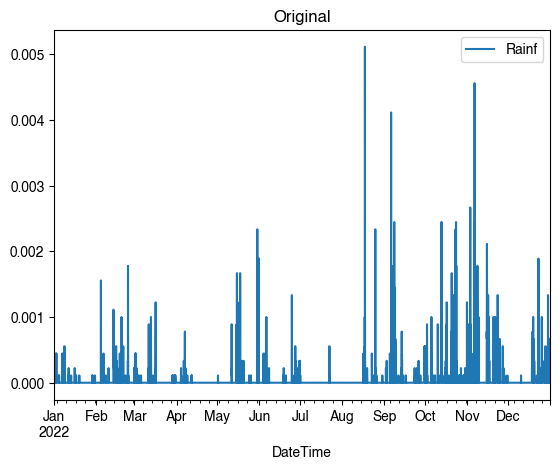

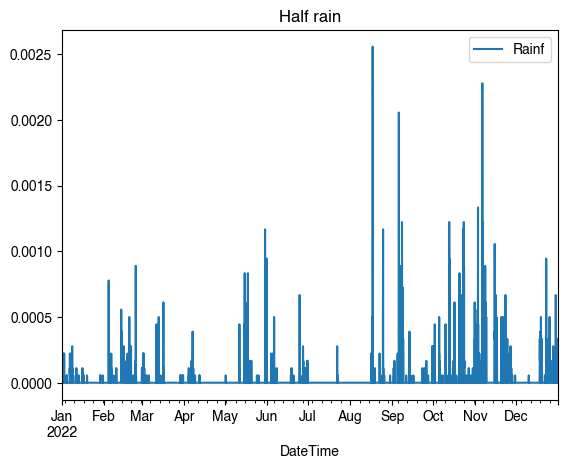

In [18]:
df.plot(y='Rainf', title='Original')
df2.plot(y='Rainf', title='Half rain')
plt.show()

# Stitching copies of the same year together
As part of the testing process for the drought model in JULES it would be useful to run over multiple instances of the same drought year. To do this we need to sappend multiple copies of the 2022 data together.

In [19]:
df_multi_year = df.copy()
tmp_df = df.copy()

for i in range (0, 5):
    tmp_df.index = tmp_df.index + pd.DateOffset(years=1)
    df_multi_year = pd.concat([df_multi_year, tmp_df])
    

df2.to_csv('../Example_data/AliceHolt_2022_processed_5_year.csv')
create_netcdf(lat, lon, df2, out_fname.replace('.nc', '_5_year.nc'),
              description = "Alice Holt 2022 data repeated 5 times. Created by Cale Baguley.")

<Axes: xlabel='DateTime'>

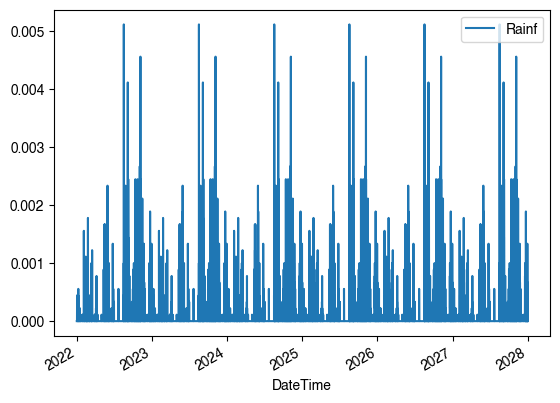

In [20]:
df_multi_year.plot(y='Rainf')

We also need to create a data set for leaf area index that is the same length as the met data.

In [23]:
df_lai = pd.read_csv('../Example_data/AliceHolt_2022_LAI.csv', index_col='date', parse_dates=True, dayfirst=True)

# Reduce to the 2022 data
df_lai = df_lai[df_lai.index.year == 2022]

<Axes: xlabel='date'>

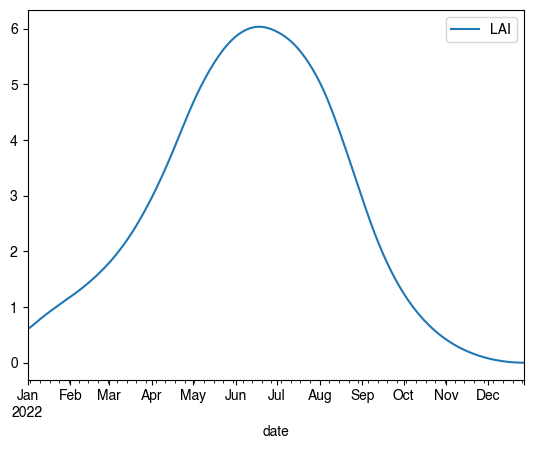

In [24]:
df_lai.plot(y='LAI')

In [ ]:
df_lai_multi_year = df_lai.copy()
tmp_df = df_lai.copy()

for i in range (0, 5):
    tmp_df.index = tmp_df.index + pd.DateOffset(years=1)
    df_lai_multi_year = pd.concat([df_lai_multi_year, tmp_df])

df_lai.to_csv('../Example_data/AliceHolt_2022_LAI_5_year.csv')
df_lai.to